# DoomTakeCover-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/doom.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [5]:
print(args.exp_name)

WorldModels


In [6]:
print(args.env_name)

DoomTakeCover-v0


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [4]:
filelist = os.listdir(DATA_DIR)

In [12]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [13]:
obs.shape

(270, 64, 64, 3)

In [21]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [22]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

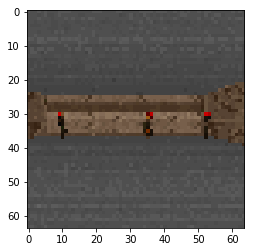

In [23]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [25]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.061  -0.3266 -1.2379  0.7143 -1.208   0.2534 -0.3451 -0.2541 -1.248  -0.4352 -0.228   0.545
 -1.2496  1.7346  0.2562  2.0476  1.6721  0.1602  0.0721  0.038  -1.1892  0.121  -0.7675  0.1439
 -1.1343 -0.8666  0.1007 -0.1798 -0.5998  0.4671 -1.0766 -0.5952  0.4751  1.3046 -1.5395  0.2398
  1.4321  0.0525  0.201  -0.0096 -0.1226 -0.978  -0.3747 -1.936   1.2033  0.1035  1.23   -0.3107
  0.0793 -1.4247 -0.2994  0.1316 -0.2381 -0.454   0.4587  0.7605  0.0288  0.9966 -0.9733 -0.2355
  0.4463 -1.0171 -0.1037  0.9323], shape=(64,), dtype=float32)


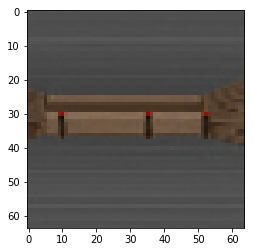

In [26]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

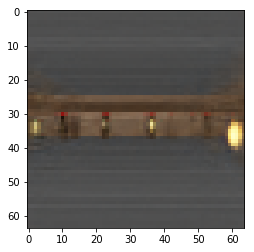

In [28]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Simulate and Store for Animation

In [29]:
def sim(c, env, vae, is_true_env=False, z_size=64, max_ep_len=1000):
    o = env.reset()
    r_list = []
    total_r_list = []
    true_frames = []
    if is_true_env:
        o, frame = o
        true_frames.append(tf.squeeze(frame))
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    else:
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    
    for _ in range(max_ep_len): # episode length is a thousand
        a = c.get_action(o)
        o, r, d, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, frame = o
            true_frames.append(tf.squeeze(frame))
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        else:
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
        
        if d:
            break
    return decoded_frames, true_frames, r_list, total_r_list

## Acting in dream environment
visualize what the agent sees when acting in the dream environment

In [30]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=True, with_obs=True)
reconstruct_episode, _, dream_r, dream_total_r = sim(c, true_env, vae, is_true_env=False, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

loading file results/WorldModels/DoomTakeCover-v0/log/DoomTakeCover-v0.cma.16.64.json
making rnn doom environment
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


<IPython.core.display.Javascript object>


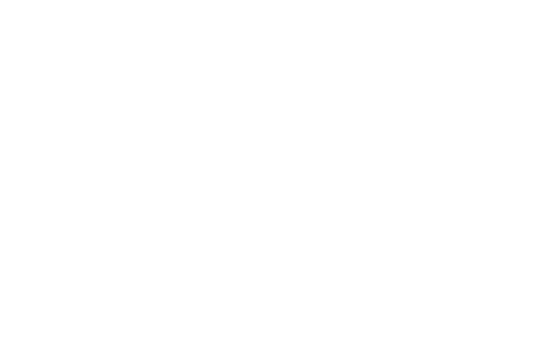

<IPython.core.display.Javascript object>


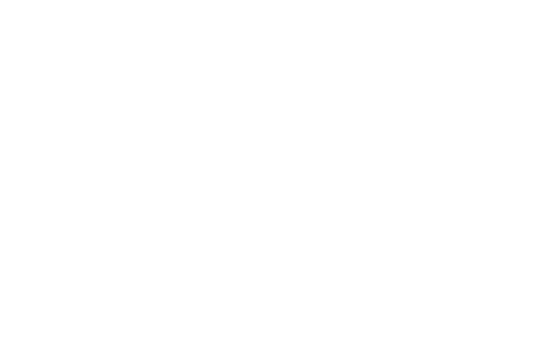

Traceback (most recent call last):
  File "/home/bharad/Desktop/python-virtual-environments/tf22/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/bharad/Desktop/python-virtual-environments/tf22/lib/python3.5/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [15]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(reconstruct_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, dream_r[frame_index+1], dream_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(reconstruct_episode), blit=True)


## Acting in true environment
visualize what the agent sees when acting in the true environment

In [31]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

loading file results/WorldModels/DoomTakeCover-v0/log/DoomTakeCover-v0.cma.16.64.json
making real doom environment


<IPython.core.display.Javascript object>


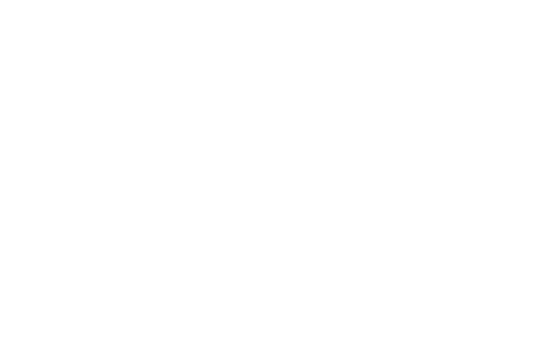

<IPython.core.display.Javascript object>


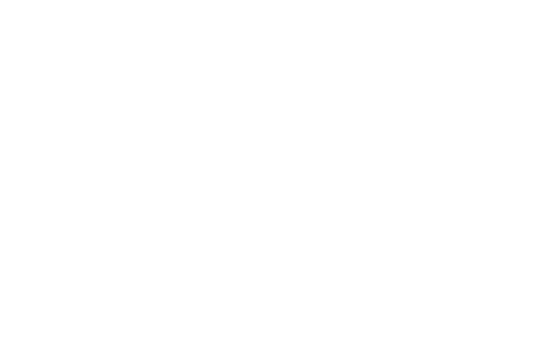

Traceback (most recent call last):
  File "/home/bharad/Desktop/python-virtual-environments/tf22/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/bharad/Desktop/python-virtual-environments/tf22/lib/python3.5/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [32]:
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(true_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Table for Controller

In [33]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.64.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))

with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
eager_data = np.array(eager_data)

eager_generation = int(eager_data[20, 0])
eager_ret = eager_data[20, 1]
eager_std = eager_data[20, 2]

og_generation = 2000
og_tau_1_ret = 868.0
og_tau_1_std = 511.0

print(eager_generation, eager_ret, eager_std)
print(og_generation, og_tau_1_ret, og_tau_1_std)

500 1337.3251953125 646.4653055797513
2000 868.0 511.0


|  | generation | returns &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|------|------|---------|
|   OG WorldModels  | 2000 | $868 \pm 511$ |
|   Eager WorldModels  | 200 | $867 \pm 557$ |

# CarRacing-v0

In [19]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [22]:
filelist = os.listdir(DATA_DIR)

In [23]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [24]:
obs.shape

(1000, 64, 64, 3)

In [25]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [26]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

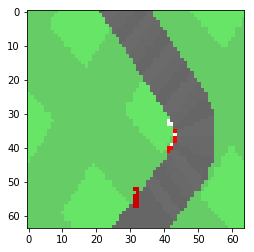

In [27]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [28]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[ 0.5057  0.2478 -0.1757  0.0447  1.7563  2.1484  0.0521 -0.2424 -0.9172  2.018  -0.3545 -0.0054
 -1.1192 -0.1535  0.1586  0.0142  0.6865 -0.243  -0.2719 -0.0567 -0.2469 -0.2462  0.0297  0.3677
 -0.2864  0.2409 -1.1472  0.3864 -0.2541  0.4444 -1.1463 -0.1563], shape=(32,), dtype=float32)


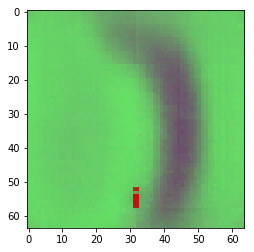

In [29]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

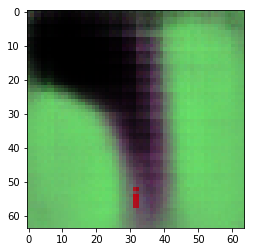

In [30]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Driving in true environment
visualize what the agent sees when driving in the true environment

In [31]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

loading file results/WorldModels/CarRacing-v0/log/CarRacing-v0.cma.16.64.json
makeing real CarRacing environment
Track generation: 1138..1426 -> 288-tiles track


<IPython.core.display.Javascript object>


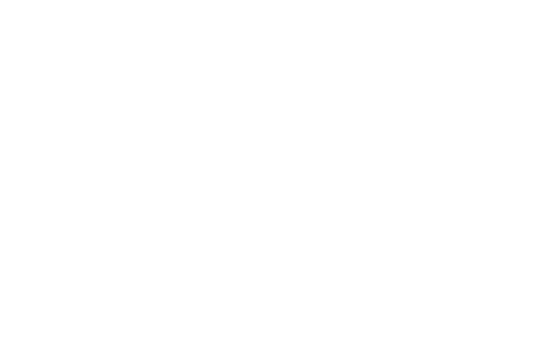

<IPython.core.display.Javascript object>


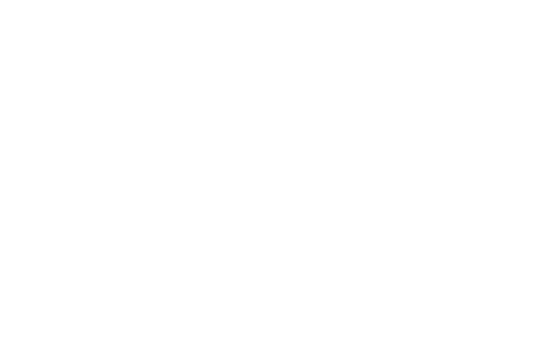

Traceback (most recent call last):
  File "/home/bharad/Desktop/python-virtual-environments/tf22/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/bharad/Desktop/python-virtual-environments/tf22/lib/python3.5/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [32]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Plot for Controller

In [33]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.64.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist_best.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

8


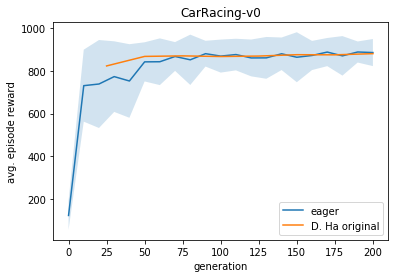

In [34]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'D. Ha original'])